# Using the Crossref API

[Crossref](https://www.crossref.org/) provides an API to get the references of a publication.

https://github.com/CrossRef/rest-api-doc


- A first idea is to go down the references for a fixed number of steps (for example 3), then keep only the articles which have been visited more than N times (for examples 3 times), and draw the upward graph starting from these articles. 
- Second idea: to look a the top cited articles in the creates graph

## to do:
- export the graph to Gephi...

- color the graph using descendance

- cluster by removing nodes from the right, sens of a non-direct graph?  min-cut

- stats:  n ref vs n citation, review vs foundational

- disconnected component for the 1st generation references: coloring 

### Knowledge reduction

- ne pas afficher les references, si au moins une des references l'utilise
- supprime un lien si un chemin plus long existe




In [405]:
%load_ext autoreload
%autoreload 2

import explorerefs as exp

In [447]:
doi = exp.getOneRandomDoi()
exp.printInfo(doi)

['Trimetallic PEPPSI-Type Palladium N-Heterocyclic Carbene Complexes - Improved Catalyst Lifetime in the Mizoroki-Heck Coupling Reaction']
[10.1002/ejic.201500542] Trimetallic PEPPSI-Type Palladium N-Heterocyclic Carbene Complexes - Improved 
 Catalyst Lifetime in the Mizoroki-Heck Coupling Reaction
Francisco Martínez-Olid; Román Andrés; Juan C. Flores; Pilar Gómez-Sal - European Journal of Inorganic Chemistry - 2015
nbr de refs:  145 - with doi: 105


In [445]:
doi = '10.1063/1.1722034' 
#doi = "10.1063/1.1654632"
doi = "10.2307/1592275"
printInfo(doi)

[10.2307/1592275] Divergent Antibody Responses to Vaccines and Divergent Body 
 Weights of Chicken Lines Selected for High and Low Humoral Responsiveness to Sheep Red Blood Cells
H. K. Parmentier; M. G. B. Nieuwland; E. Rijke; G. De Vries Reilingh; J. W. Schrama - Avian Diseases - 1996
nbr de refs:  0 - with doi: 0


## Create the graph

In [ ]:
doi = "10.1063/1.1654632"
doi = "10.1038/s41528-018-0030-4"
#doi = "10.1063/1.3284082"
doi = '10.1038/nmat1350'

In [456]:
refgraph = exp.Referencesgraph(doi)
refgraph.nodes

279 articles loaded from cache


{'10.1002/ejic.201500542': {'citedBy': [], 'gen': 0}}

In [464]:
refgraph.grow()

refgraph.printstats()

- done -          
nbre nodes: 1743
last gen: 2


In [465]:
nRemaining = [ len( refgraph.nodesVisitedTwice(N=N) ) for N in range( 9 ) ]
nRemaining

[1743, 1742, 351, 101, 42, 29, 17, 9, 2]

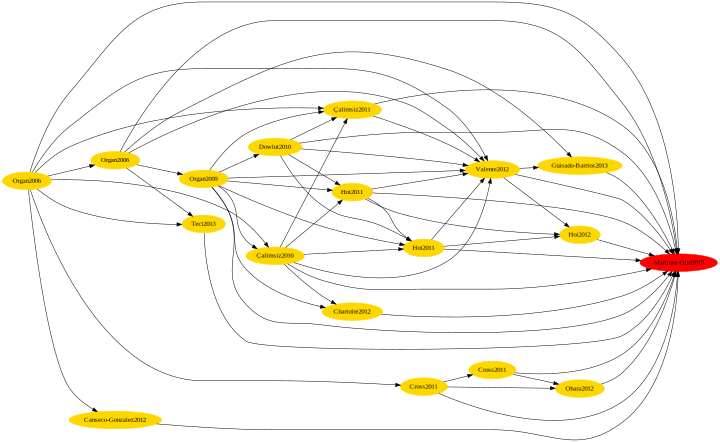

In [466]:
DG = refgraph.builtGraphviz( N = 8 )
plt = SVG(DG.render())
display(plt)

## Stats

In [467]:
refgraph.mostCited( )

[10.1002/anie.200805661] Pd-PEPPSI-IPent: An Active, Sterically Demanding Cross-Coupling Catalyst and 
 Its Application in the Synthesis of Tetra-Ortho-Substituted Biaryls
Michael G. Organ; Selçuk Çalimsiz; Mahmoud Sayah; Ka Hou Hoi; Alan J. Lough - Angewandte Chemie International Edition - 2009
nbr de refs:  35 - with doi: 31

[10.1002/chem.200600206] A User-Friendly, All-Purpose Pd–NHC (NHC=N-Heterocyclic Carbene) Precatalyst for 
 the Negishi Reaction: A Step Towards a Universal Cross-Coupling Catalyst
Michael G. Organ; Stephanie Avola; Igor Dubovyk; Niloufar Hadei; Eric Assen B. Kantchev; Christopher J. O'Brien; Cory Valente - Chemistry - A European Journal - 2006
nbr de refs:  56 - with doi: 1

[10.1002/anie.200703883] Heterocyclic Carbenes: Synthesis and Coordination Chemistry
F. Ekkehardt Hahn; Mareike C. Jahnke - Angewandte Chemie International Edition - 2008
nbr de refs:  695 - with doi: 10

[10.1021/ja057704z] Modified (NHC)Pd(allyl)Cl (NHC =N-Heterocyclic Carbene) Complexes 

# Famille

In [469]:
nodesToDraw, linksToDraw = refgraph.nodesToDraw(N = 8 )

In [470]:
cited = { target for source, target in linksToDraw }

In [471]:
roots = [ node for node in nodesToDraw if node not in cited ]
print( len(roots) )

1


In [472]:
upwardnodes = {}
for source, target in linksToDraw:
    if source in upwardnodes:
        upwardnodes[source].append( target )
    else:
        upwardnodes[source] = [ target ]
        
# add the summit
for node in nodesToDraw:
    if node not in upwardnodes:
        upwardnodes[node] = []

In [473]:
roots

['10.1002/chem.200600206']

In [474]:
origins = {}
toVisit = [ [r, r]  for r in  roots  ]

while toVisit:
    node, origin = toVisit.pop()
    
    if node in origins:
        origins[node].add( origin )
    else:
        origins[node] = set( [origin] )
       
    for target in upwardnodes[node]:
        toVisit.append((target, origin))
        
origins = { doi: ' '.join(sorted(oriSet)) for doi, oriSet in origins.items() }

In [475]:
len( origins ), len( upwardnodes )

(18, 18)

In [476]:

colorGen = ['red', 'gold1', 'cyan3', 'darkorchid2', 'chartreuse2', 'lightsalmon2', 'orchid',
            'springgreen2', 'sienna2', 'tomato', 'olivedrab', 'orange1', 'lightsteelblue', 'lightgray', 
           'crimson', 'azure2']

colorGen = colorGen + colorGen*3
colorOrigin = {  ori:col for  ori, col in zip( list( set( origins.values() ) ), colorGen) }


In [477]:
len(colorGen), len(set( origins.values() ))

(64, 1)

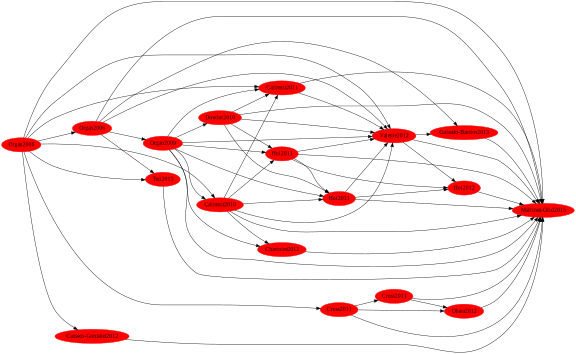

In [479]:
# -- Use Graphviz to draw the graph --

DG = Digraph(comment='hello', format='svg', engine='dot' , graph_attr={'size':'8' })#})'root':doi} )
DG.graph_attr['rankdir'] = 'LR'

for doi in nodesToDraw:
    info =  refgraph.nodes[doi]
    color = colorOrigin[  origins[doi] ]
    DG.node(parsedoi(doi), color=color, style='filled', label= buildlabel(doi))
    
for source, target in linksToDraw:
    DG.edge(parsedoi(source), parsedoi(target))  

plt = SVG(DG.render())
display(plt)

## Draft

In [300]:
import networkx as nx

G = nx.DiGraph()
for source, target in AllGenRefs:
    
    if outDegree[source]>0:
        G.add_edge(source, target) 

nx.drawing.draw(G) 

NameError: name 'AllGenRefs' is not defined